In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from modules.numeric import *

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [4]:
from celluloid import Camera
from IPython.display import HTML

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='computer modern roman')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,bm,physics,lmodern}')

In [28]:
phi4 = Phi4()
X0 = 10

def chi(H, mu, nu):
    return np.arctanh((mu*H)**nu)

def varphi(x, mu, nu):
    return -mu*np.tanh(x)**nu

def phi_dirichlet(x, H):
    assert H > -1
    mu = 1
    nu = 1 if H < 1 else -1
    return np.r_[[1]*len(x)] if H == 1 else varphi(x - chi(H, mu, nu), mu, nu)

def y0(x, v, H):
    return np.stack((
        phi_dirichlet(x, H) + phi4.kink(x + X0, 0, v) - 1,
        phi4.kink_dt(x + X0, 0, v)
    ))

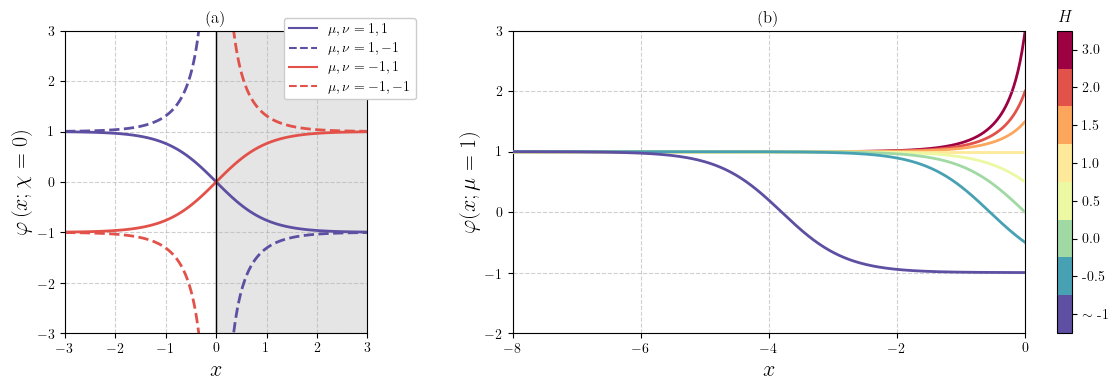

In [15]:
values = np.r_[-0.999, -0.5, 0, 0.5, 1, 1.5, 2, 3]
cmap = plt.get_cmap('Spectral_r', len(values))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.8]})

cs = {1:cmap(0), -1:cmap(len(values)-2)}
ls = {1:'-', -1:'--'}

x = np.linspace(-3, 3, 250)
for mu in (1, -1):
    for nu in (1, -1):
        ax1.plot([], [], c=cs[mu], ls=ls[nu], label=r'$\mu, \nu = {%s}, {%s}$'%(mu, nu))
        for i, xi in enumerate((x[x < 0], x[x > 0])):
            ax1.plot(xi, varphi(xi, mu, nu), c=cs[mu], ls=ls[nu], lw=2)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(-3, 3)

ax1.set_xlabel(r'$x$', fontsize=16)
ax1.set_ylabel(r'$\varphi\left(x;\chi=0\right)$', fontsize=16)
        
ax1.grid(alpha=0.6, ls='--')
ax1.legend(framealpha=1, bbox_to_anchor=(0.7, 0.75))
ax1.set_title('(a)')

ax1.axvline(0, ls='-', lw=1, c='k')
ax1.set_aspect('equal')

ax1.fill_betweenx((-3, 3), 0, 5, alpha=0.1, color='k')

x = np.linspace(-8, 0, 500)

for i, H in enumerate(values):
    ax2.plot(x, phi_dirichlet(x, H), c=cmap(i), lw=2, zorder=len(values)-i)

ax2.set_ylim(-2, 3)
ax2.set_xlim(x.min(), x.max())

ax2.set_yticks((-2, -1, 0, 1, 2, 3))

ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$\varphi(x; \mu=1)$', fontsize=16)
ax2.set_xticks((0, -2, -4, -6, -8))
ax2.grid(alpha=0.6, ls='--', zorder=-1)
ax2.set_title('(b)')

dvs = np.r_[-1.5, values]
cbar = fig.colorbar(ScalarMappable(norm=BoundaryNorm(dvs, ncolors=len(dvs)), cmap=ListedColormap([cmap(i) for i in range(len(dvs))])), ax=ax2)
cbar.ax.set_yticks((dvs[:-1] + dvs[1:])/2, (r'$\sim$ -1', *values[1:]))
cbar.minorticks_off()
cbar.ax.set_title(r'$H$')

fig.tight_layout()
fig.savefig('reports/dirichlet/solutions.pdf', bbox_inches='tight', dpi=2000, pad_inches=0)
plt.show()

In [16]:
L = 100
N = 1024
DX = L/(N - 1)
DT = 4e-2

In [23]:
collider = Collider(
    x_lattice= (-L, 0, N), 
    dt= DT, 
    order= 4,
    y0= y0,
    pot_diff= phi4.diff,
    boundaries= ('reflective', 'dirichlet'),
    integrator='sy6',
)

def plot(v, H, ax=None):
    if ax == None: ax = plt.gca()
    collider.rb.param = H
    lat, Y = collider.run(X0/v + L, v=v, H=H)
    y, dydt = Y[:, 0], Y[:, 1]
    ax.imshow(y.T, cmap='seismic', vmin=-1.4, vmax=1.4, extent=lat.extent('t', 'x'), aspect='auto', origin='lower')
    ax.set_ylim(-20, 0)
    return lat, y, dydt

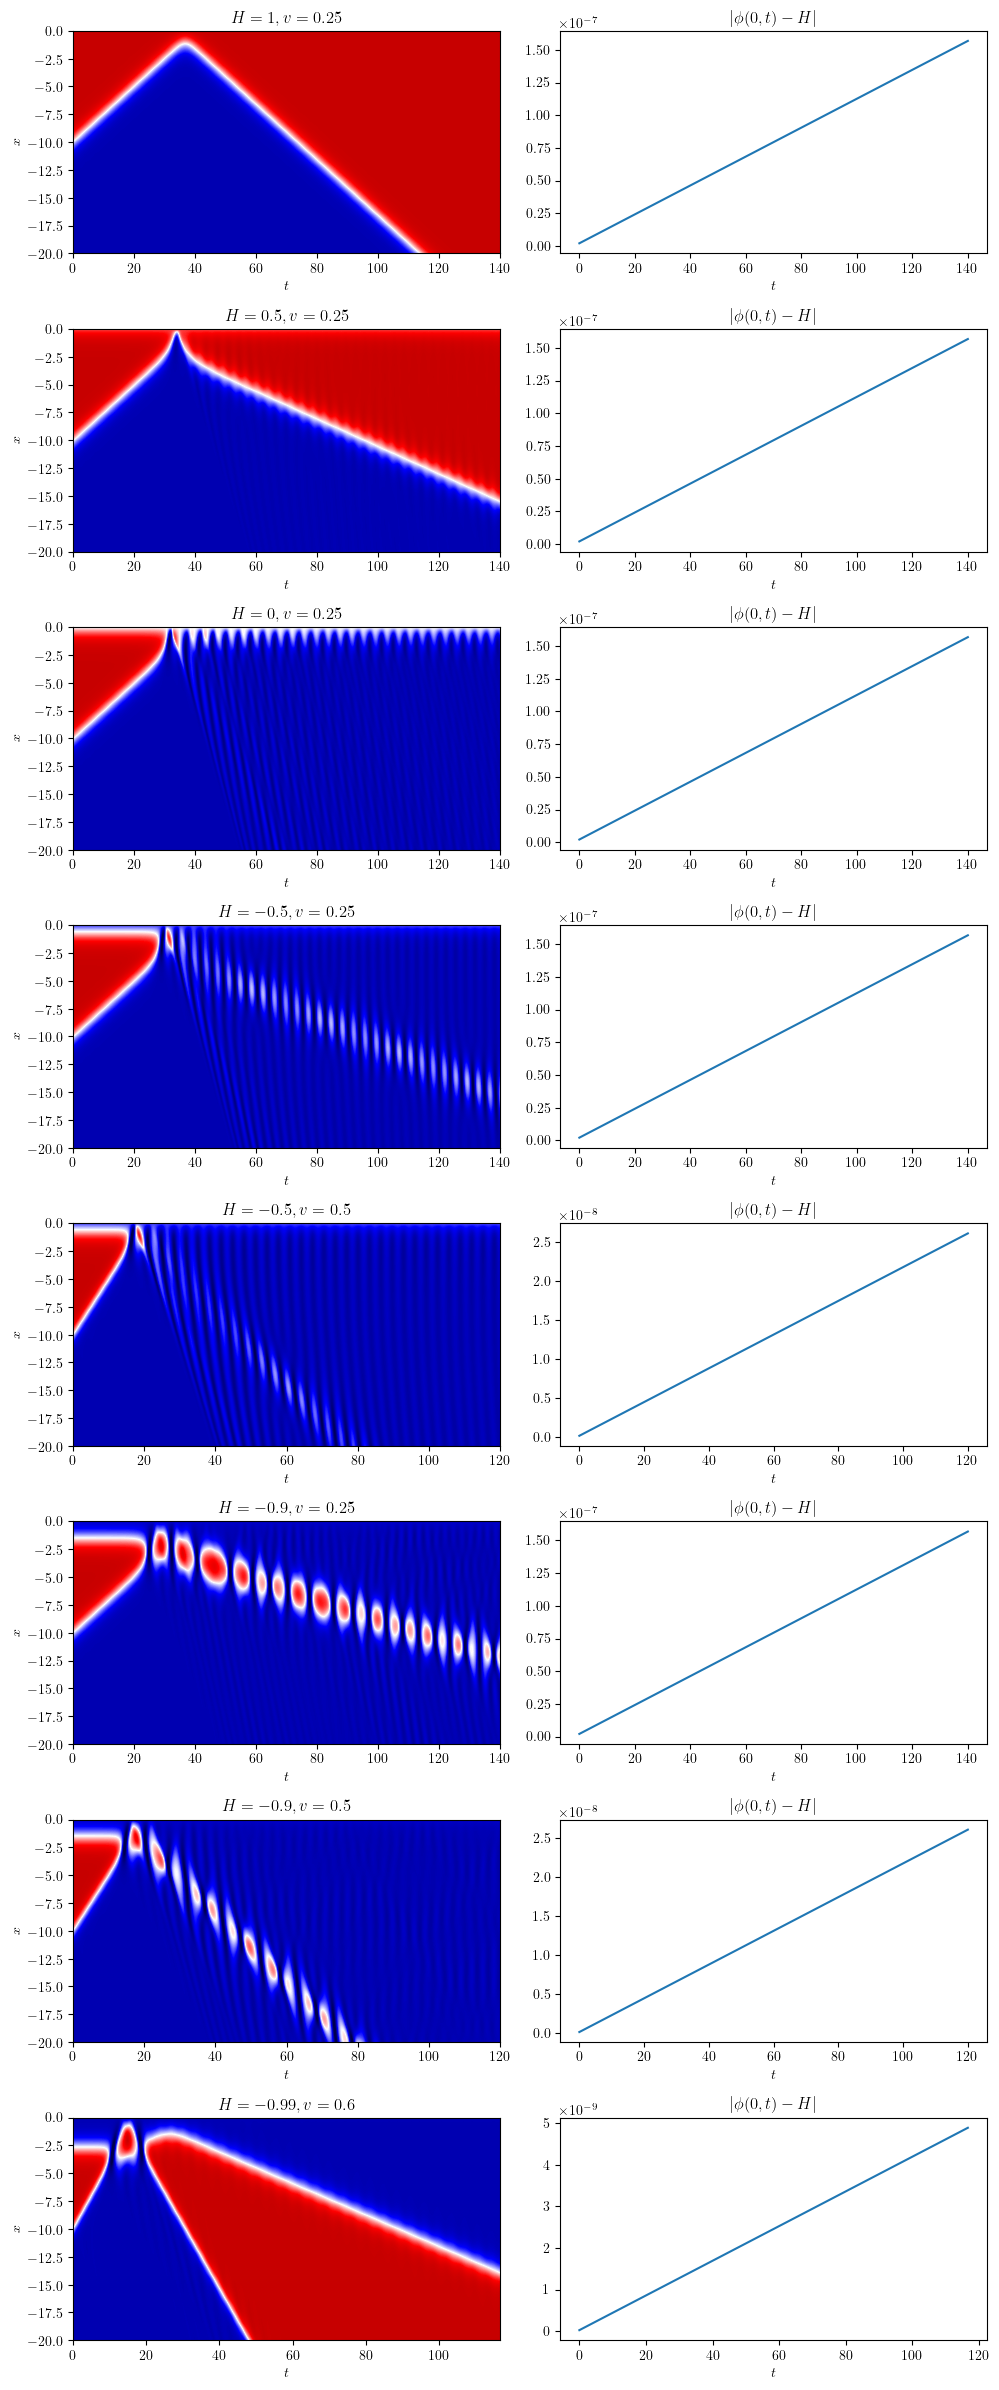

In [13]:
params = (
    (1, 0.25),
    (0.5, 0.25),
    (0, 0.25),
    (-0.5, 0.25),
    (-0.5, 0.5),
    (-0.9, 0.25),
    (-0.9, 0.5),
    (-0.99, 0.6),
)
p = len(params)
_, axs = plt.subplots(p, 2, figsize=(10, p*3))

for (ax1, ax2), (H, v) in zip(axs, params):
    lat, y, dydt = plot(v, H, ax=ax1)
    ax2.plot(lat.t, abs(y[:, -1] - H))
    ax1.set_title(r'$H=%s, v=%s$'%(H, v))
    ax2.set_title('$|\phi(0, t)-H|$')
    ax2.set_xlabel('$t$')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x$')

plt.tight_layout()
plt.show()

In [43]:
def animate(v, H):
    collider.rb.param = H
    lat, Y = collider.run(t_final=X0/v + L, v=v, H=H)

    fig = plt.figure(figsize=(10, 4))
    cam = Camera(fig)
    plt.xlim(-20, 0)
    plt.ylim(-1.5, 1.5)
    plt.grid(alpha=0.6, ls='--', zorder=-1)
    plt.tight_layout()

    for u in Y[::10, 0]:
        plt.plot(lat.x, u, 'k-', alpha=0.5, zorder=0)
        plt.scatter(lat.x, u, marker='o', c=u, cmap='seismic', vmin=-1.4, vmax=1.4, s=15, zorder=1)
        plt.plot(lat.x[-1], [H], 'C1*', clip_on=False, markersize=10, zorder=2)
        cam.snap()

    plt.close()
    return HTML(cam.animate(interval=50).to_html5_video())

In [40]:
animate(v=0.2, H=0.51)

In [44]:
animate(v=0.5, H=0)

In [45]:
animate(v=0.9, H=0)